In [7]:
! pip install --user beautifulsoup4


In [8]:
! pip install --user folium

In [2]:
#Importing Libraries

from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests # library to handle requests
import json 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import urllib.request
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import sys
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
print('All libraries imported')

All libraries imported


In [3]:
#Scraping wikipedia

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
req = urllib.request.urlopen(url)
article = req.read().decode()
article2 = str(article.encode(sys.stdout.encoding, errors='replace'))
#print(article2)
with open('Postal_Codes-M.html', 'w') as fo:
    fo.write(article2)
    
article = open('Postal_Codes-M.html').read()
soup = BeautifulSoup(article, 'html.parser')
table = soup.find('table', class_='sortable')
table_rows = table.find_all('tr')
l = []
for tr in table_rows:
    if(('Not assigned' in str(tr))==False):
        td = tr.find_all('td')
        row=[tr.text for tr in td]
        l.append(row)
df = pd.DataFrame(l)
df.drop(index = 0, inplace = True)
df.columns = ['Postal Code','Borough','Neighbourhood' ]
for column in df:
    df[column] = df[column].str.replace('\\\\n','')
df.head()



,Postal Code,Borough,Neighbourhood
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"
5,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government"


In [4]:
url = 'http://cocl.us/Geospatial_data'
coords = requests.get(url, allow_redirects=True)
open('c_table.csv', 'wb').write(coords.content)    
coord_table = pd.read_csv('c_table.csv')
df_coord = pd.merge(df, coord_table, on='Postal Code', how='right')
df_coord.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494


In [5]:
Toronto_df = df_coord[df_coord['Borough'].str.contains('Toronto')]
Toronto_df.set_index(['Postal Code'], inplace=True)
Toronto_df.reset_index(inplace = True)
Toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [6]:
CLIENT_ID = 'BWOB1P21JS33S2PXKD3GZFTBMCXAYROV5XDSAJR4Y2EINCUT' # your Foursquare ID
CLIENT_SECRET = '1QLIPVLNYGB40IUESTCFUO3ISCM003N1H31MFUYTJT5OKEI3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

radius = 500
LIMIT = 100

Your credentails:
CLIENT_ID: BWOB1P21JS33S2PXKD3GZFTBMCXAYROV5XDSAJR4Y2EINCUT
CLIENT_SECRET:1QLIPVLNYGB40IUESTCFUO3ISCM003N1H31MFUYTJT5OKEI3


In [7]:
#categories = (4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06373d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06375d81259,4d4b7105d754a06378d81259)


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06373d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
            
        # make the GET request
        results = requests.get(url).json()
        counter = 0
        
        #returns venue name and category
        for v in results['response']['venues']:
            venues_list.append([(
            name, 
            lat, 
            lng,
            results['response']['venues'][counter]['name'],
            results['response']['venues'][counter]['categories'][0]['name'])])
            counter = counter + 1 


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
lat = 43.65426
lng = -79.360636
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06373d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
            
# make the GET request
results = requests.get(url).json()

In [20]:
len(results['response']['venues'])


50

In [15]:
Toronto_venues = getNearbyVenues(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen\'s Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport

In [9]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.head()

NameError: name 'Toronto_venues' is not defined

In [17]:
Toronto_venues.size

7685

In [18]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

Toronto_onehot.set_index('Neighborhood', inplace = True)
Toronto_onehot.reset_index(inplace = True)

#Toronto_onehot.head()
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Accessories Store,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Astrologer,Athletics & Sports,...,Train Station,Tree,Vegetarian / Vegan Restaurant,Video Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Berczy Park,0.0,0.0,0.000000,0.0,0.021277,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.021739,0.0,0.065217,0.021739,0.0,0.0,0.021739,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Business reply mail Processing Centre, South C...",0.0,0.0,0.021277,0.0,0.042553,0.000000,0.0,0.0,0.042553,...,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Central Bay Street,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Pub,Pharmacy,Liquor Store,Grocery Store,Office,Butcher,Clothing Store,Jewelry Store,Belgian Restaurant,Steakhouse
1,"Brockton, Parkdale Village, Exhibition Place",Convenience Store,Speakeasy,Art Gallery,Tattoo Parlor,Grocery Store,Food & Drink Shop,Salon / Barbershop,Fruit & Vegetable Store,Jewelry Store,Spa
2,"Business reply mail Processing Centre, South C...",Board Shop,Park,Music Store,Art Gallery,Athletics & Sports,Storage Facility,Brewery,Grocery Store,Farmers Market,Flower Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Historic Site,Tree,Convenience Store,Sculpture Garden,Island,Park,Performing Arts Venue,Bar,Boutique,Harbor / Marina
4,Central Bay Street,Pharmacy,Shopping Mall,Bar,Clothing Store,Grocery Store,Convenience Store,Department Store,Pizza Place,Electronics Store,Skating Rink


In [37]:
Sum_of_squared_distances = []
silhouette = []
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
K = range(2,30)
for k in K:
    
    #elbow
    km = KMeans(n_clusters=k)
    inert = km.fit(Toronto_grouped_clustering)
    Sum_of_squared_distances.append(inert.inertia_)
    
    #silhouette
    preds = km.fit_predict(Toronto_grouped_clustering)
    centers = km.cluster_centers_
    silhouette=silhouette+[silhouette_score(Toronto_grouped_clustering, preds)]


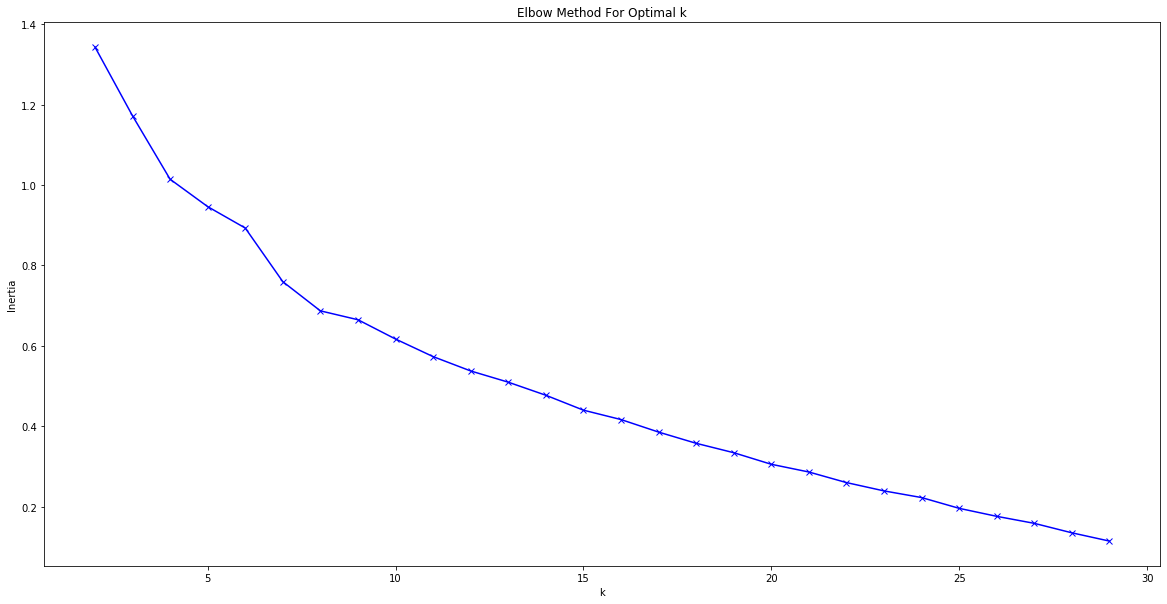

In [22]:
fig= plt.figure(figsize=(20,10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

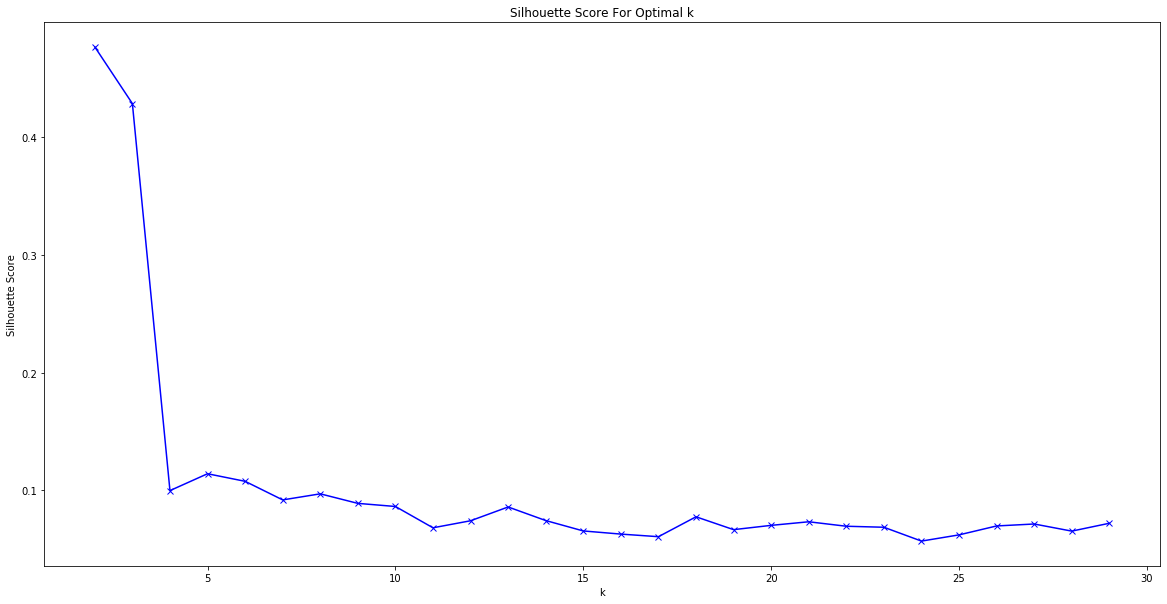

In [23]:
fig= plt.figure(figsize=(20,10))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [41]:
# set number of clusters
kclusters = 3



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0])

In [42]:
# add clustering labels
nvs = neighborhoods_venues_sorted
nvs.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(nvs.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Park,Pub,Automotive Shop,Furniture / Home Store,Auto Dealership,Flower Shop,Design Studio,Café,Beer Store,Sporting Goods Shop
1,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494,1,Pharmacy,Park,Gym / Fitness Center,Liquor Store,Discount Store,Historic Site,Pub,Building,Lounge,Bowling Alley
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Grocery Store,Supermarket,Pharmacy,Shopping Mall,Gym,Convenience Store,Furniture / Home Store,Bar,Clothing Store,Camera Store
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Bank,Pub,Department Store,Sports Bar,Butcher,Museum,Pharmacy,Park,Shopping Mall,Farmers Market
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Park,Playground,Hardware Store,Health Food Store,Salon / Barbershop,Pub,Dance Studio,College Gym,Spa,Smoke Shop


In [43]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",0,Park,Pub,Automotive Shop,Furniture / Home Store,Auto Dealership,Flower Shop,Design Studio,Café,Beer Store,Sporting Goods Shop
4,The Beaches,0,Park,Playground,Hardware Store,Health Food Store,Salon / Barbershop,Pub,Dance Studio,College Gym,Spa,Smoke Shop
7,Christie,0,Grocery Store,Hardware Store,Convenience Store,Gym / Fitness Center,Design Studio,Nightclub,Tattoo Parlor,Speakeasy,Flower Shop,Bike Shop
9,"Dufferin, Dovercourt Village",0,Convenience Store,Athletics & Sports,Grocery Store,Gas Station,Electronics Store,Lounge,Performing Arts Venue,Pharmacy,Playground,Clothing Store
10,"Harbourfront East, Union Station, Toronto Islands",0,Park,Harbor / Marina,Restaurant,Grocery Store,Sports Bar,Pub,Scenic Lookout,Plaza,Performing Arts Venue,Brewery


In [44]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Queen\'s Park, Ontario Provincial Government",1,Pharmacy,Park,Gym / Fitness Center,Liquor Store,Discount Store,Historic Site,Pub,Building,Lounge,Bowling Alley
2,"Garden District, Ryerson",1,Grocery Store,Supermarket,Pharmacy,Shopping Mall,Gym,Convenience Store,Furniture / Home Store,Bar,Clothing Store,Camera Store
3,St. James Town,1,Bank,Pub,Department Store,Sports Bar,Butcher,Museum,Pharmacy,Park,Shopping Mall,Farmers Market
5,Berczy Park,1,Pub,Pharmacy,Liquor Store,Grocery Store,Office,Butcher,Clothing Store,Jewelry Store,Belgian Restaurant,Steakhouse
6,Central Bay Street,1,Pharmacy,Shopping Mall,Bar,Clothing Store,Grocery Store,Convenience Store,Department Store,Pizza Place,Electronics Store,Skating Rink


In [45]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,2,Spa,Playground,Strip Club,Garden,Dive Bar,Entertainment Service,Film Studio,Field,Festival,Fast Food Restaurant


In [32]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 6, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [26]:
LIMIT = 100

def getNearbyVenues_Overall(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url1 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7104d754a06370d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        url2 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06373d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        url3 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06376d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        url4 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06377d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        url5 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06378d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
            
        # make the GET request
        results1 = requests.get(url1).json() #Arts and Entertainment
        results2 = requests.get(url2).json() #Event
        results3 = requests.get(url3).json() #Nightlife
        results4 = requests.get(url4).json() #Outdoors and Recreation
        results5 = requests.get(url5).json() #Shops and Services
        
        
        venues_list.append([(
                name, 
                lat, 
                lng,
                len(results1['response']['venues']),
                len(results2['response']['venues']),
                len(results3['response']['venues']),
                len(results4['response']['venues']),
                len(results5['response']['venues']))])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Arts and Entertainment',  
                  'Event','Nightlife', 'Outdoors and Recreation', 'Shops and Services']
    
    return(nearby_venues)

In [27]:
Toronto_venues_100 = getNearbyVenues_Overall(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen\'s Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport

In [23]:
Toronto_venues_Overall = getNearbyVenues_Overall(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen\'s Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport

In [34]:
Toronto_venues_100.head()

,Neighborhood,Arts and Entertainment,Event,Nightlife,Outdoors and Recreation,Shops and Services
0,"Regent Park, Harbourfront",49,4,28,44,44
1,"Queen\'s Park, Ontario Provincial Government",44,0,42,43,42
2,"Garden District, Ryerson",46,1,47,44,50
3,St. James Town,44,1,50,43,40
4,The Beaches,5,0,7,19,37


In [35]:
Tvc_sorted = Toronto_venues_100.copy()
#Tvc_sorted.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude'], inplace = True)
Tvc_sorted.head()

,Neighborhood,Arts and Entertainment,Event,Nightlife,Outdoors and Recreation,Shops and Services
0,"Regent Park, Harbourfront",49,4,28,44,44
1,"Queen\'s Park, Ontario Provincial Government",44,0,42,43,42
2,"Garden District, Ryerson",46,1,47,44,50
3,St. James Town,44,1,50,43,40
4,The Beaches,5,0,7,19,37


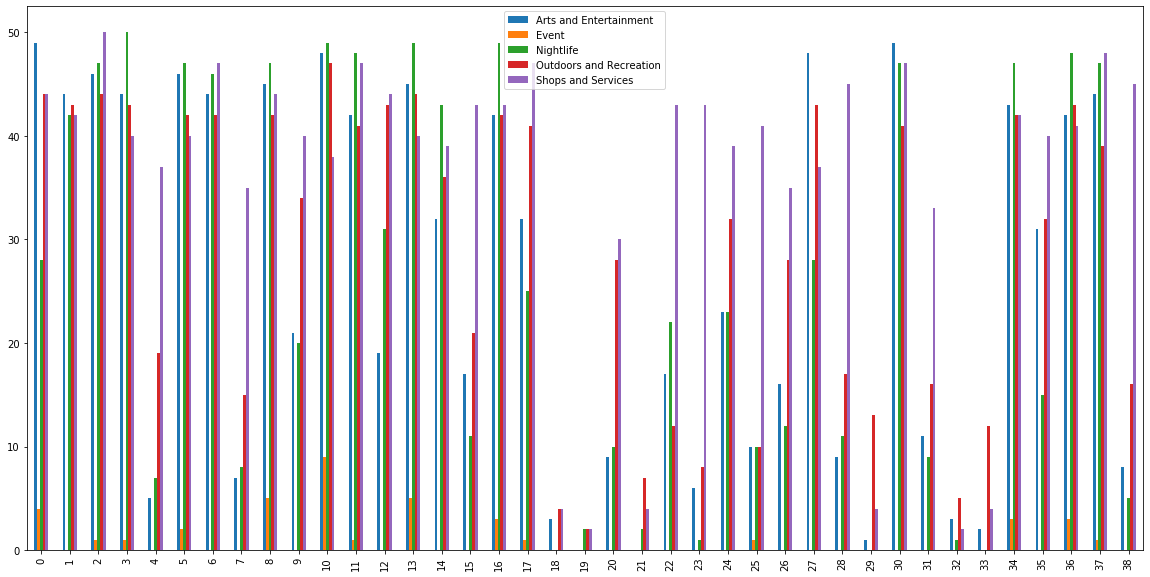

In [38]:
Tvc_sorted.plot(kind = 'bar', figsize = (20,10))

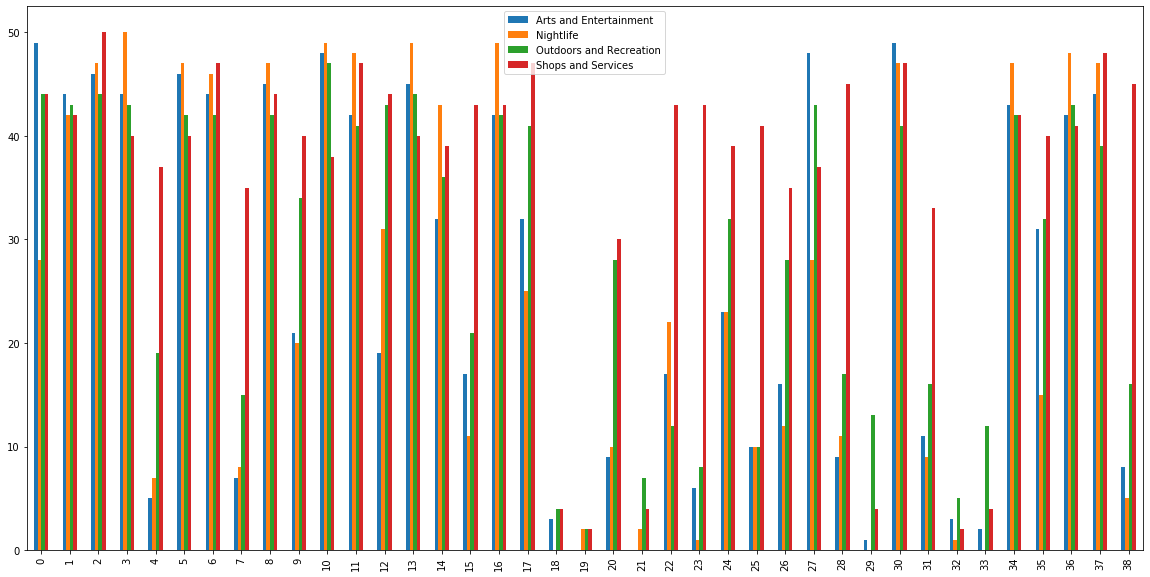

In [42]:
#Tvc_sorted.drop(columns = ['Event'], inplace = True)
Tvc_sorted.plot(kind = 'bar', figsize = (20,10))

In [74]:
Tvc_sorted['Totals'] = Tvc_sorted.sum(axis = 1)

In [131]:
Tvc_sorted_Ratio = Tvc_sorted.copy()
Tvc_sorted_Ratio.head()

,Neighborhood,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services,Totals
0,"Regent Park, Harbourfront",49,28,44,44,165
1,"Queen\'s Park, Ontario Provincial Government",44,42,43,42,171
2,"Garden District, Ryerson",46,47,44,50,187
3,St. James Town,44,50,43,40,177
4,The Beaches,5,7,19,37,68


In [132]:

Tvc_sorted_Ratio['Arts and Entertainment']=Tvc_sorted_Ratio['Arts and Entertainment']/Tvc_sorted_Ratio['Totals']
Tvc_sorted_Ratio['Nightlife']=Tvc_sorted_Ratio['Nightlife']/Tvc_sorted_Ratio['Totals']
Tvc_sorted_Ratio['Outdoors and Recreation']=Tvc_sorted_Ratio['Outdoors and Recreation']/Tvc_sorted_Ratio['Totals']
Tvc_sorted_Ratio['Shops and Services']=Tvc_sorted_Ratio['Shops and Services']/Tvc_sorted_Ratio['Totals']
Tvc_sorted_Ratio.drop(columns = 'Totals', inplace = True)

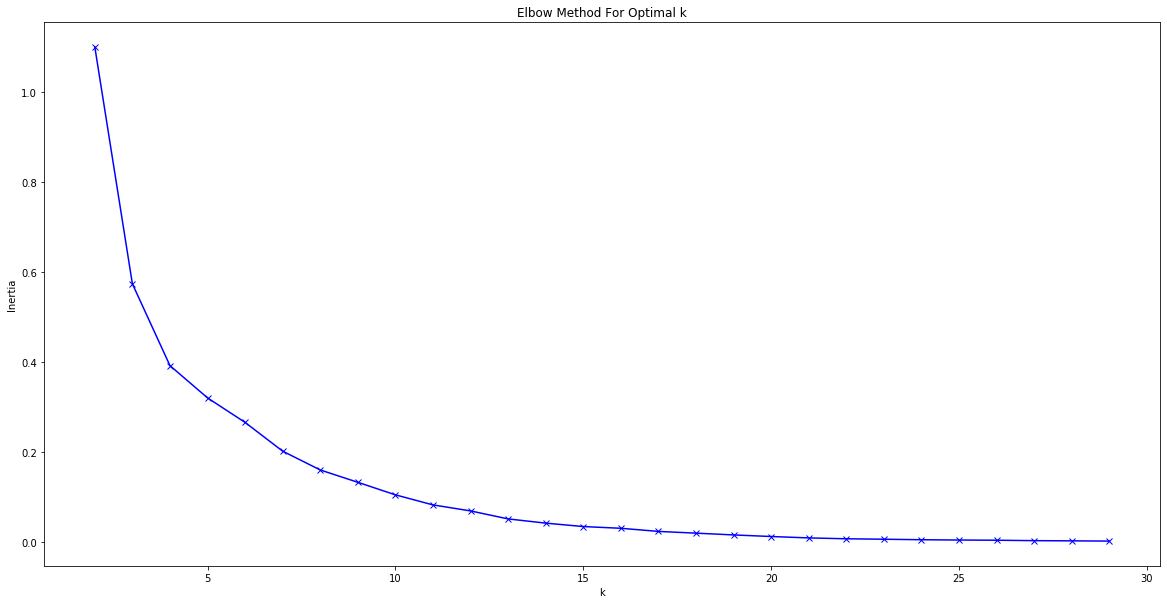

In [133]:
Sum_of_squared_distances = []
silhouette = []
Tvc_sorted_Clustering = Tvc_sorted_Ratio.drop('Neighborhood', 1)
K = range(2,30)
for k in K:
    
    #elbow
    km = KMeans(n_clusters=k)
    inert = km.fit(Tvc_sorted_Clustering)
    Sum_of_squared_distances.append(inert.inertia_)
    
    #silhouette
    preds = km.fit_predict(Tvc_sorted_Clustering)
    centers = km.cluster_centers_
    silhouette=silhouette+[silhouette_score(Tvc_sorted_Clustering, preds)]

fig= plt.figure(figsize=(20,10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

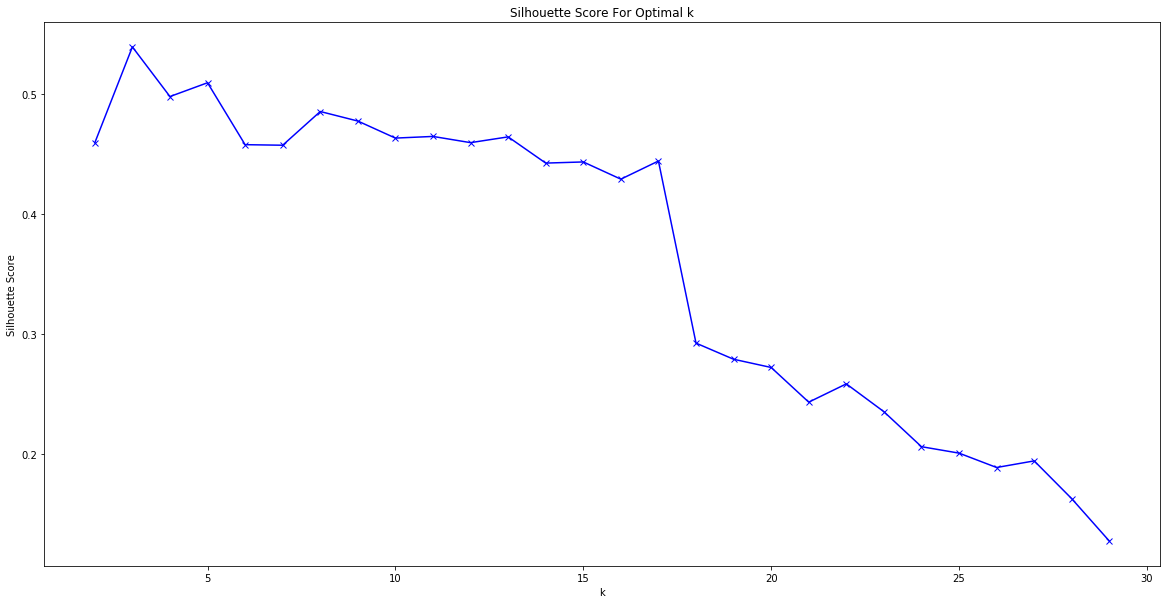

In [134]:
fig= plt.figure(figsize=(20,10))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [135]:
# set number of clusters
kclusters = 5



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tvc_sorted_Clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 1, 3, 3, 1, 3, 0])

In [136]:
# add clustering labels
Final = Tvc_sorted_Ratio.copy()
Final.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged_final = Toronto_df.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged_final = Toronto_merged_final.join(Final.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged_final.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,0.296970,0.169697,0.266667,0.266667
1,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494,3,0.257310,0.245614,0.251462,0.245614
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,0.245989,0.251337,0.235294,0.267380
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,0.248588,0.282486,0.242938,0.225989
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,0.073529,0.102941,0.279412,0.544118


In [144]:
#Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]
Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 0]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,0,0.182609,0.173913,0.295652,0.347826
12,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,0.138686,0.226277,0.313869,0.321168
17,M4M,East Toronto,Studio District,43.659526,-79.340923,0,0.220690,0.172414,0.282759,0.324138
18,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0.272727,0.000000,0.363636,0.363636
20,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0,0.116883,0.129870,0.363636,0.389610
24,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,0,0.196581,0.196581,0.273504,0.333333
26,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,0.175824,0.131868,0.307692,0.384615
32,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,0,0.272727,0.090909,0.454545,0.181818
35,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0,0.262712,0.127119,0.271186,0.338983


In [138]:
Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 1]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,0.073529,0.102941,0.279412,0.544118
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,1,0.107692,0.123077,0.230769,0.538462
15,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,0.184783,0.119565,0.228261,0.467391
22,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,1,0.180851,0.234043,0.127660,0.457447
23,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,1,0.103448,0.017241,0.137931,0.741379
25,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,1,0.140845,0.140845,0.140845,0.577465
28,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,1,0.109756,0.134146,0.207317,0.548780
31,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,1,0.159420,0.130435,0.231884,0.478261
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,1,0.108108,0.067568,0.216216,0.608108


In [139]:
Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 2]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,2,0.055556,0.0,0.722222,0.222222
33,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,2,0.111111,0.0,0.666667,0.222222


In [140]:
Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 3]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,0.296970,0.169697,0.266667,0.266667
1,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494,3,0.257310,0.245614,0.251462,0.245614
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,0.245989,0.251337,0.235294,0.267380
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,0.248588,0.282486,0.242938,0.225989
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,3,0.262857,0.268571,0.240000,0.228571
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3,0.245810,0.256983,0.234637,0.262570
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,3,0.252809,0.264045,0.235955,0.247191
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,3,0.263736,0.269231,0.258242,0.208791
11,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,3,0.235955,0.269663,0.230337,0.264045
13,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,3,0.252809,0.275281,0.247191,0.224719


In [141]:
Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 4]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services
19,M5N,Central Toronto,Roselawn,43.711695,-79.416936,4,0.0,0.333333,0.333333,0.333333
21,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,4,0.0,0.153846,0.538462,0.307692
